In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy
import yaml

In [2]:
# Fetch the submission YAML
submission_path = "/root/software/NUISANCEMC/data/nu/T2K/CH/numu/PRD.108.112009/testout"
submission = "submission.yaml"

data_files = {}

with open("/".join([submission_path, submission]), 'r') as file:
    submission_yaml = yaml.safe_load_all(file)
    for doc in submission_yaml:
        if "data_file" in doc:
            df = doc["data_file"]
            with open("/".join([submission_path, df]), 'r') as datafile:
                data_files[df] = yaml.safe_load(datafile)
                
print(data_files.keys())

dict_keys(['cross_section-offaxis.yaml', 'cross_section-onaxis.yaml', 'joint_uncertainty-onoffaxis.yaml', 'flux-onaxis-nominal-fine.yaml', 'flux-onaxis-nominal-coarse.yaml', 'flux-onaxis-postfit-fine.yaml', 'flux-onaxis-postfit-coarse.yaml', 'flux-offaxis-nominal-fine.yaml', 'flux-offaxis-nominal-coarse.yaml', 'flux-offaxis-postfit-fine.yaml', 'flux-offaxis-postfit-coarse.yaml'])


In [6]:
onaxis_doc = data_files["cross_section-onaxis.yaml"]
offaxis_doc = data_files["cross_section-offaxis.yaml"]

onaxis_xs_quals = {kv["name"]:kv["value"] for kv in onaxis_doc["dependent_variables"][0]["qualifiers"]}
print("On Axis: %s" % onaxis_xs_quals["target"])
print("  Target: %s" % onaxis_xs_quals["target"])
print("  Probe Species: %s" % onaxis_xs_quals["probe_species"])
print("  Probe Spectrum: %s" % onaxis_xs_quals["probe_spectrum"])
on_axis_flux_table = data_files["%s.yaml" %  onaxis_xs_quals["probe_spectrum"]]


offaxis_xs_quals = {kv["name"]:kv["value"] for kv in offaxis_doc["dependent_variables"][0]["qualifiers"]}
print("On Axis: %s" % offaxis_xs_quals["target"])
print("  Target: %s" % offaxis_xs_quals["target"])
print("  Probe Species: %s" % offaxis_xs_quals["probe_species"])
print("  Probe Spectrum: %s" % offaxis_xs_quals["probe_spectrum"])
off_axis_flux_table = data_files["%s.yaml" % offaxis_xs_quals["probe_spectrum"]]

On Axis: CH
  Target: CH
  Probe Species: numu
  Probe Spectrum: flux-onaxis-postfit-coarse
On Axis: CH
  Target: CH
  Probe Species: numu
  Probe Spectrum: flux-offaxis-postfit-coarse


# Fluxes

In [16]:
on_axis_flux = pn.convert.HistFrame.from_yaml_str(str(on_axis_flux_table))
off_axis_flux = pn.convert.HistFrame.from_yaml_str(str(off_axis_flux_table))

on_axis_flux_fine = pn.convert.HistFrame.from_yaml_str(str(data_files['flux-onaxis-postfit-fine.yaml']))
off_axis_flux_fine = pn.convert.HistFrame.from_yaml_str(str(data_files['flux-offaxis-postfit-fine.yaml']))

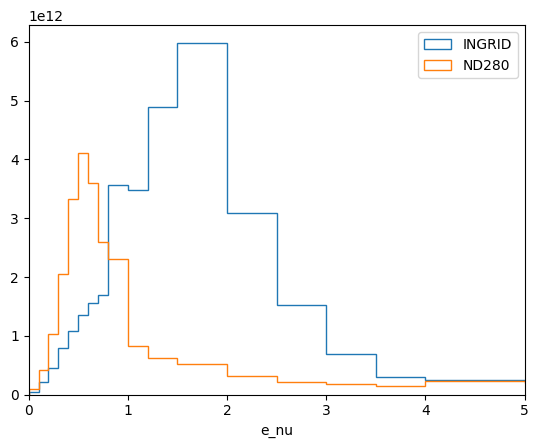

In [8]:
on_axis_flux.mpl().hist(label="INGRID", histtype="step")
off_axis_flux.mpl().hist(label="ND280", histtype="step")

plt.xlim([0,5])

plt.legend()
plt.show()

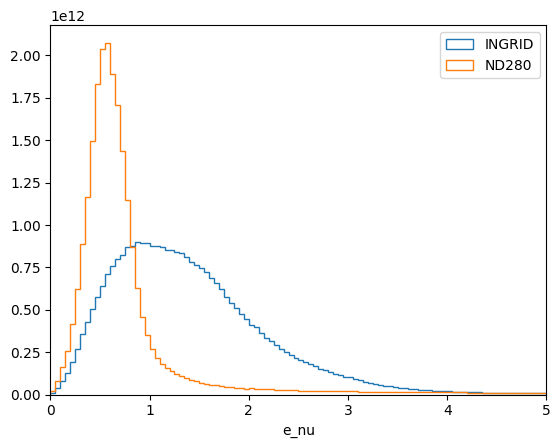

In [17]:
on_axis_flux_fine.mpl().hist(label="INGRID", histtype="step")
off_axis_flux_fine.mpl().hist(label="ND280", histtype="step")

plt.xlim([0,5])

plt.legend()
plt.show()

In [ ]:
# import ROOT

In [ ]:
# fo = ROOT.TFile.Open("PRD108.fluxes.root","RECREATE")
# pn.convert.ROOT.ToTH1(on_axis_flux, "on_axis_flux").Write()
# pn.convert.ROOT.ToTH1(off_axis_flux, "off_axis_flux").Write()
# fo.Write()
# fo.Close()

# Generate some events

Now you will have to generate some event files with these fluxes. If you have access to the NUISANCE2 CLI (to be ported), you might run

```bash
nuis gen NEUT -f PRD108.fluxes.root,on_axis_flux -n 200000 -p numu -t CH -o onaxis.CH.neutvect.root
nuis gen NEUT -f PRD108.fluxes.root,off_axis_flux -n 200000 -p numu -t CH -o offaxis.CH.neutvect.root
```

In [9]:
evs_on_axis = pn.EventSource("prdgen/onaxis.CH.neutvect.root")
if not evs_on_axis:
    print("Error: failed to open input file")

evs_off_axis = pn.EventSource("prdgen/offaxis.CH.neutvect.root")
if not evs_off_axis:
    print("Error: failed to open input file")

# Cross Sections

In [10]:
#load the select/project functions
pps.load_file("/".join([submission_path, "analysis.cxx"]))

True

In [11]:
on_axis_filter_name = onaxis_xs_quals["select"]
on_axis_proj_names = []
for iv in onaxis_doc["independent_variables"]:
    varname = iv["header"]["name"]
    on_axis_proj_names.append(onaxis_xs_quals["project:%s" % varname])

on_axis_filter_func = pps.select.get(on_axis_filter_name)
on_axis_proj_funcs = [ pps.project.get(x) for x in on_axis_proj_names]

off_axis_filter_name = offaxis_xs_quals["select"]
off_axis_proj_names = []
for iv in offaxis_doc["independent_variables"]:
    varname = iv["header"]["name"]
    off_axis_proj_names.append(offaxis_xs_quals["project:%s" % varname])

off_axis_filter_func = pps.select.get(off_axis_filter_name)
off_axis_proj_funcs = [ pps.project.get(x) for x in off_axis_proj_names]

In [12]:
fg_on_axis = pn.EventFrameGen(evs_on_axis).filter(on_axis_filter_func)
for i,fn in enumerate(on_axis_proj_funcs):
    fg_on_axis.add_column(on_axis_proj_names[i],fn)

fg_off_axis = pn.EventFrameGen(evs_off_axis).filter(off_axis_filter_func)
for i,fn in enumerate(off_axis_proj_funcs):
    fg_off_axis.add_column(off_axis_proj_names[i],fn)

In [13]:
ef_on_axis = fg_on_axis.firstArrow(int(1E6))
ef_off_axis = fg_off_axis.firstArrow(int(1E6))

In [14]:
on_axis_xs_data = pn.convert.HistFrame.from_yaml_str(str(onaxis_doc))
off_axis_xs_data = pn.convert.HistFrame.from_yaml_str(str(offaxis_doc))

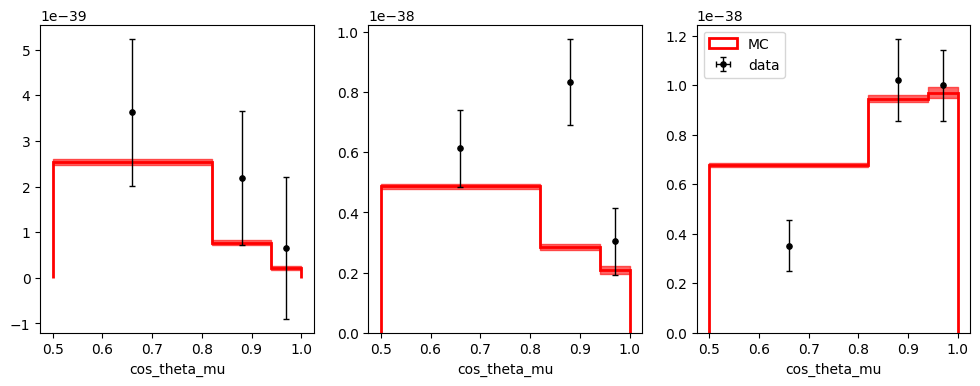

In [21]:
ctheta_bins = on_axis_xs_data.project(1).binning.bins

#make a fillable histogram from the data
on_axis_xs_mc = on_axis_xs_data.make_HistFrame()
on_axis_xs_mc.fill_from_Arrow(ef_on_axis, off_axis_proj_names)

#fatx is in pb/A, -> 1pb is 10^-36 want /12 to take it back to the /N from the generator
sf = fg_on_axis.norm_info().fatx_per_sumweights() * (1E-36) /12

#scale it to the right units
on_axis_xs_mc.sumweights = on_axis_xs_mc.sumweights * sf
on_axis_xs_mc.variances = on_axis_xs_mc.variances * (sf**2)

on_axis_xs_prediction = on_axis_xs_mc.finalise(True)

fig, axes = plt.subplots(1,3, figsize=(12,4))

for i,ax in enumerate(axes):
    xslice_prediction = on_axis_xs_prediction.slice(1, ctheta_bins[i][0].low).slice(0,[0,5],True)
    xslice_data = on_axis_xs_data.slice(1, ctheta_bins[i][0].low).slice(0,[0,5],True)

    xslice_prediction.mpl().hist(plot_axis=ax, color="#F00", histtype="step", linewidth=2, errorband_color="#F009", label="MC")
    xslice_data.mpl().errorbar(plot_axis=ax, marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)
    
plt.legend()
plt.show()

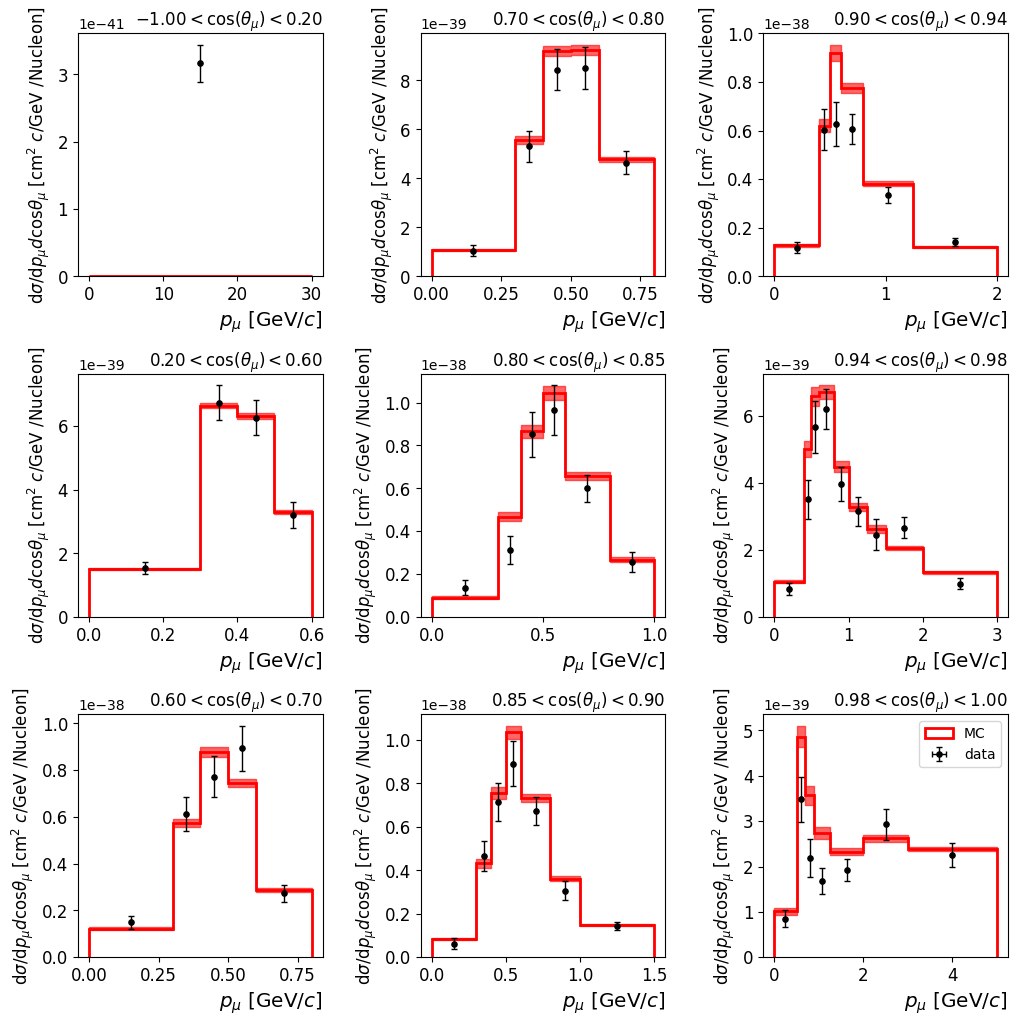

In [22]:
ctheta_bins = off_axis_xs_data.project(1).binning.bins

#make a fillable histogram from the data
off_axis_xs_mc = off_axis_xs_data.make_HistFrame()
off_axis_xs_mc.fill_from_Arrow(ef_off_axis, off_axis_proj_names)

#fatx is in pb/A, -> 1pb is 10^-36 want /12 to take it back to the /N from the generator
sf = fg_off_axis.norm_info().fatx_per_sumweights() * (1E-36) /12

#scale it to the right units
off_axis_xs_mc.sumweights = off_axis_xs_mc.sumweights * sf
off_axis_xs_mc.variances = off_axis_xs_mc.variances * (sf**2)

off_axis_xs_prediction = off_axis_xs_mc.finalise(True)

fig, axes = plt.subplots(3,3, figsize=(12,12), gridspec_kw={"hspace":0.4,"wspace":0.4})

for i in range(len(ctheta_bins)):
    ax = axes[i%3,i//3]
    xslice_data = off_axis_xs_data.slice(1, ctheta_bins[i][0].low)
    xslice_prediction = off_axis_xs_prediction.slice(1, ctheta_bins[i][0].low)

    #remove trash bin if its not the only bin
    if len(xslice_data.binning.bins) > 1:
        xslice_data = xslice_data.slice(0,[0,5],True)
        xslice_prediction = xslice_prediction.slice(0,[0,5],True)
        
    xslice_prediction.mpl().hist(plot_axis=ax, color="#F00", histtype="step", linewidth=2, errorband_color="#F009", label="MC")
    xslice_data.mpl().errorbar(plot_axis=ax, marker=".", markersize=7.5, color="#000", label="data", linewidth=0, elinewidth=1, capsize=2.5)
    ax.set_xlabel(r"$p_\mu$ [GeV/$c$]", loc="right", fontsize="x-large")
    ax.set_ylabel(r"$\text{d}\sigma/\text{d}p_{\mu}d\text{cos}\theta_\mu\ [\text{cm}^{2}\ c/\text{GeV}\ /\text{Nucleon}]$", fontsize="large")
    ax.tick_params(axis='x', labelsize="large")
    ax.tick_params(axis='y', labelsize="large")

    ax.text(1, 1.03, r"$%.2f < \text{cos}(\theta_\mu) < %.2f$" % (ctheta_bins[i][0].low,ctheta_bins[i][0].high), 
            horizontalalignment="right", transform=ax.transAxes, fontsize="large")
    
plt.legend()
plt.show()

In [24]:
joint_covar = pn.convert.Covariance.from_yaml_str(str(data_files["joint_uncertainty-onoffaxis.yaml"]))
print(joint_covar.shape)

(70, 70)


In [25]:
def calc_chisq(h_data, h_mc, h_invcov):

    #Calculate the difference between data and MC and transform into a column vector
    diff = (h_data - h_mc).reshape(1, -1)

    #Use vector/matrix multiplication to calculate chi-square
    chisq = diff @ h_invcov @ diff.T
    return chisq.item()

In [26]:
offon_axis_xs_prediction = np.append(off_axis_xs_prediction.values[:,0],on_axis_xs_prediction.values[:,0])
print(len(offon_axis_xs_prediction))
offon_axis_xs_data = np.append(off_axis_xs_data.values[:,0],on_axis_xs_data.values[:,0])
print(len(offon_axis_xs_data))

70
70


In [27]:
print("chi2 = %s" % calc_chisq(offon_axis_xs_data, offon_axis_xs_prediction, np.linalg.inv(joint_covar) ))

chi2 = 858.7192432613592
